# Imports

In [2]:
from itertools import combinations
from pathlib import Path
from typing import Literal, Optional

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

In [3]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (10, 6)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [6]:
SAVE_DIR = Path("extraction_results")
TEST_ON_TRAIN = False

UQA = "unifiedqa-t5-11b"
GPTJ = "gpt-j-6B"
DEBERTA = "deberta-v2-xxlarge-mnli"
SHORT_NAMES = {UQA: "UQA", GPTJ: "GPT-J", DEBERTA: "DeBERTa"}

UQA_GOOD_DS = [
    "imdb",
    "amazon-polarity",
    "ag-news",
    "dbpedia-14",
    "copa",
    "boolq",
    "story-cloze",
]
GPTJ_GOOD_DS = ["imdb", "amazon-polarity", "ag-news", "dbpedia-14"]
DEBERTA_GOOD_DS = [
    "imdb",
    "amazon-polarity",
    "ag-news",
    "dbpedia-14",
    "copa",
    "rte",
    "boolq",
    "qnli",
    "piqa",
]
MODEL_GOOD_DS = {UQA: UQA_GOOD_DS, GPTJ: GPTJ_GOOD_DS, DEBERTA: DEBERTA_GOOD_DS}

RCCS_ITERS = 20

TOGETHER_COL = "blue"
SEPARATE_COL = "orange"
RANDOM_COL = "grey"
LR_COL = "green"
MAX_COL = "red"
MIN_COL = "purple"

# derived constants
if TEST_ON_TRAIN:
    SAVE_DIR = SAVE_DIR / "test_on_train"
TEST_ON_TRAIN_suffix = "\n(On the train set)" if TEST_ON_TRAIN else ""

# Utils

In [40]:
def load_probs(
    model_name: str,
    train: str,
    test: str,
    method: str = "CCS",
    save_dir: Optional[Path] = None,
):
    save_dir = save_dir or SAVE_DIR

    dir = (save_dir / "rccs") if method.startswith("RCCS") else save_dir
    folder = dir / f"states_{model_name}_{method}" / train
    pattern = f"{test}*_{method}.csv" if test != "all" else f"*_{method}.csv"
    return pd.concat([pd.read_csv(f) for f in folder.glob(pattern)])


def load_stats(
    model_name: str,
    train: str,
    test: str,
    method: str = "CCS",
    prefix: str = "normal",
    save_dir: Optional[Path] = None,
):
    save_dir = save_dir or SAVE_DIR

    dir = (save_dir / "rccs") if method.startswith("RCCS") else save_dir
    csvs = dir.glob(f"{model_name}_{prefix}_*.csv")
    dfs = [pd.read_csv(f) for f in csvs]

    if not dfs:
        raise ValueError(
            f"No csvs found for {model_name}, {train}, {test}, {method}"
        )

    # Filter by train & method
    dfs = [df[(df["train"] == train) & (df["method"] == method)] for df in dfs]

    if test != "all":
        # Filter by test
        dfs = [df[df["test"] == test] for df in dfs]
        assert all(len(df) == 1 for df in dfs)
        return {
            k: np.array([df[k].values[0] for df in dfs])
            for k in ["accuracy", "loss", "cons_loss", "sim_loss"]
            if all(k in df.columns for df in dfs)
        }  # k: (seeds,)

    # Average by seed across datasets
    return {
        k: np.array([df[k].mean() for df in dfs])
        for k in ["accuracy", "loss", "cons_loss", "sim_loss"]
        if all(k in df.columns for df in dfs)
    }  # k: (seeds,)


def load_rccs_stats(model_name: str, train: str, test: str):
    stats_per_it = [
        load_stats(model_name, train, test, f"RCCS{it}")
        for it in range(RCCS_ITERS)
    ]

    return {
        k: np.array([stats[k] for stats in stats_per_it])
        for k in ["accuracy", "loss", "cons_loss", "sim_loss"]
        if all(k in stats for stats in stats_per_it)
    }  # k: (it, seeds)


def ccs_loss(p0, p1):
    return np.minimum(p0, p1).mean() + np.square(p0 + p1 - 1).mean()


def load_params(
    model_name: str, train: str, prefix: str = "normal", method: str = "CCS"
):
    coefs_files = (SAVE_DIR / "params").glob(
        f"coef_{model_name}_{prefix}_{method}_all_{train}_*.npy"
    )
    intercepts_files = (SAVE_DIR / "params").glob(
        f"intercept_{model_name}_{prefix}_{method}_all_{train}_*.npy"
    )
    coefs = [np.load(f) for f in coefs_files]
    intercepts = [np.load(f) for f in intercepts_files]

    # Average by dataset
    return {
        "coefs": np.array([coef for coef in coefs]),  # (seed, it, nhid)
        "intercepts": np.array(
            [intercept for intercept in intercepts]
        ),  # (seed, it, nhid)
    }


def boxplots(positions, data, label, color, width=0.5, obj=plt, hatches=""):
    ax = obj.boxplot(
        data,
        positions=positions,
        notch=False,
        patch_artist=True,
        showfliers=False,
        boxprops=dict(facecolor="none", color=color),
        capprops=dict(color=color),
        whiskerprops=dict(color=color),
        flierprops=dict(color=color, markeredgecolor=color),
        medianprops=dict(color=color),
        widths=[width] * len(positions),
    )
    boxes = ax["boxes"]
    for box in boxes:
        box.set_hatch(hatches)
    return [(boxes[0], label)]


def plot_stacked_bar(positions, sim_loss, cons_loss, label, col, width, ax):
    sim_means = np.mean(sim_loss, axis=1)
    cons_means = np.mean(cons_loss, axis=1)
    total_loss_std = np.std(np.array(sim_loss) + np.array(cons_loss), axis=1)
    ax.bar(
        positions,
        sim_means,
        width=width,
        color=col,
        label=f"{label}, confidence loss",
        hatch="O",
    )
    ax.bar(
        positions,
        cons_means,
        width=width,
        color=col,
        bottom=sim_means,
        label=f"{label}, similarity loss",
        hatch=".",
        yerr=total_loss_std,
    )

# CCS is able to find a single direction which correctly classifies statements across datasets

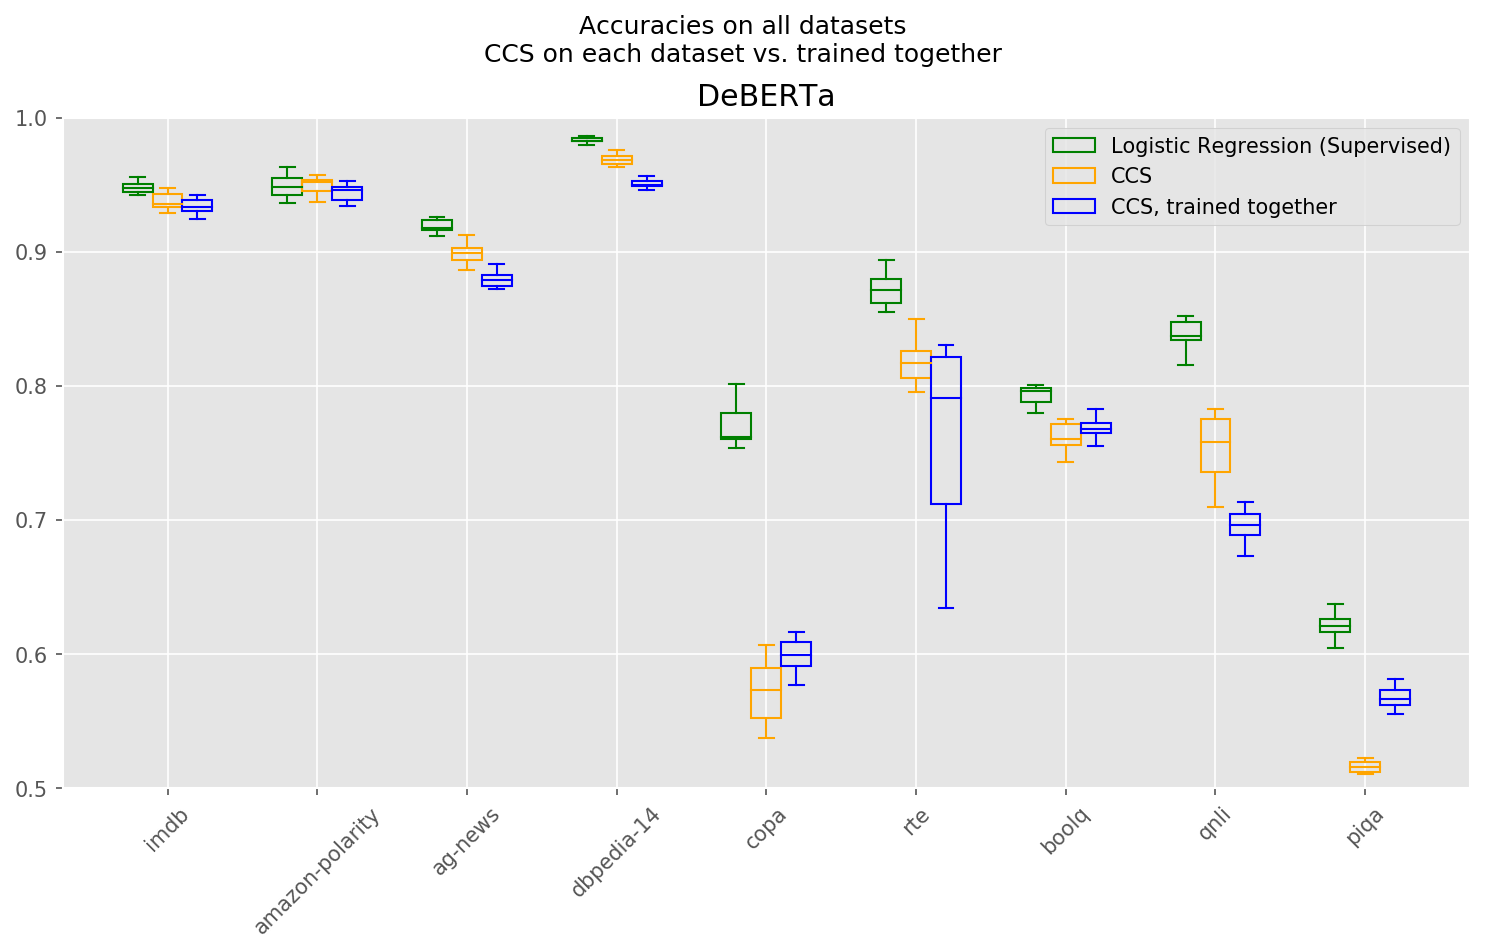

In [32]:
models = [DEBERTA]
prefix = "normal-dot"

fig, axs = plt.subplots(1, len(models), sharey=True)
if len(models) == 1:
    axs = [axs]

for i, (ax, model) in enumerate(zip(axs, models)):
    bar_names = MODEL_GOOD_DS[model]
    lr_accs = [
        load_stats(model, d, d, "LR", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    separate_accs = [
        load_stats(model, d, d, "CCS", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    together_accs = [
        load_stats(model, "all", d, "CCS", prefix=prefix)["accuracy"]
        for d in bar_names
    ]

    x_pos = np.arange(len(bar_names))
    width = 0.2
    legend_info = []
    legend_info += boxplots(
        x_pos - width,
        lr_accs,
        "Logistic Regression (Supervised)",
        LR_COL,
        width=width,
        obj=ax,
    )
    legend_info += boxplots(
        x_pos, separate_accs, "CCS", SEPARATE_COL, width=width, obj=ax
    )
    legend_info += boxplots(
        x_pos + width,
        together_accs,
        "CCS, trained together",
        TOGETHER_COL,
        width=width,
        obj=ax,
    )
    if i == len(models) - 1:
        ax.legend([l[0] for l in legend_info], [l[1] for l in legend_info])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_names, rotation=45)
    ax.set_ylim(0.5, 1)
    ax.set_title(SHORT_NAMES[model])
plt.suptitle(
    f"Accuracies on all datasets\nCCS on each dataset vs. trained together{TEST_ON_TRAIN_suffix}",
    y=1.05,
)
plt.tight_layout()
plt.show()

# CCS does so better than random, but not by a huge margin

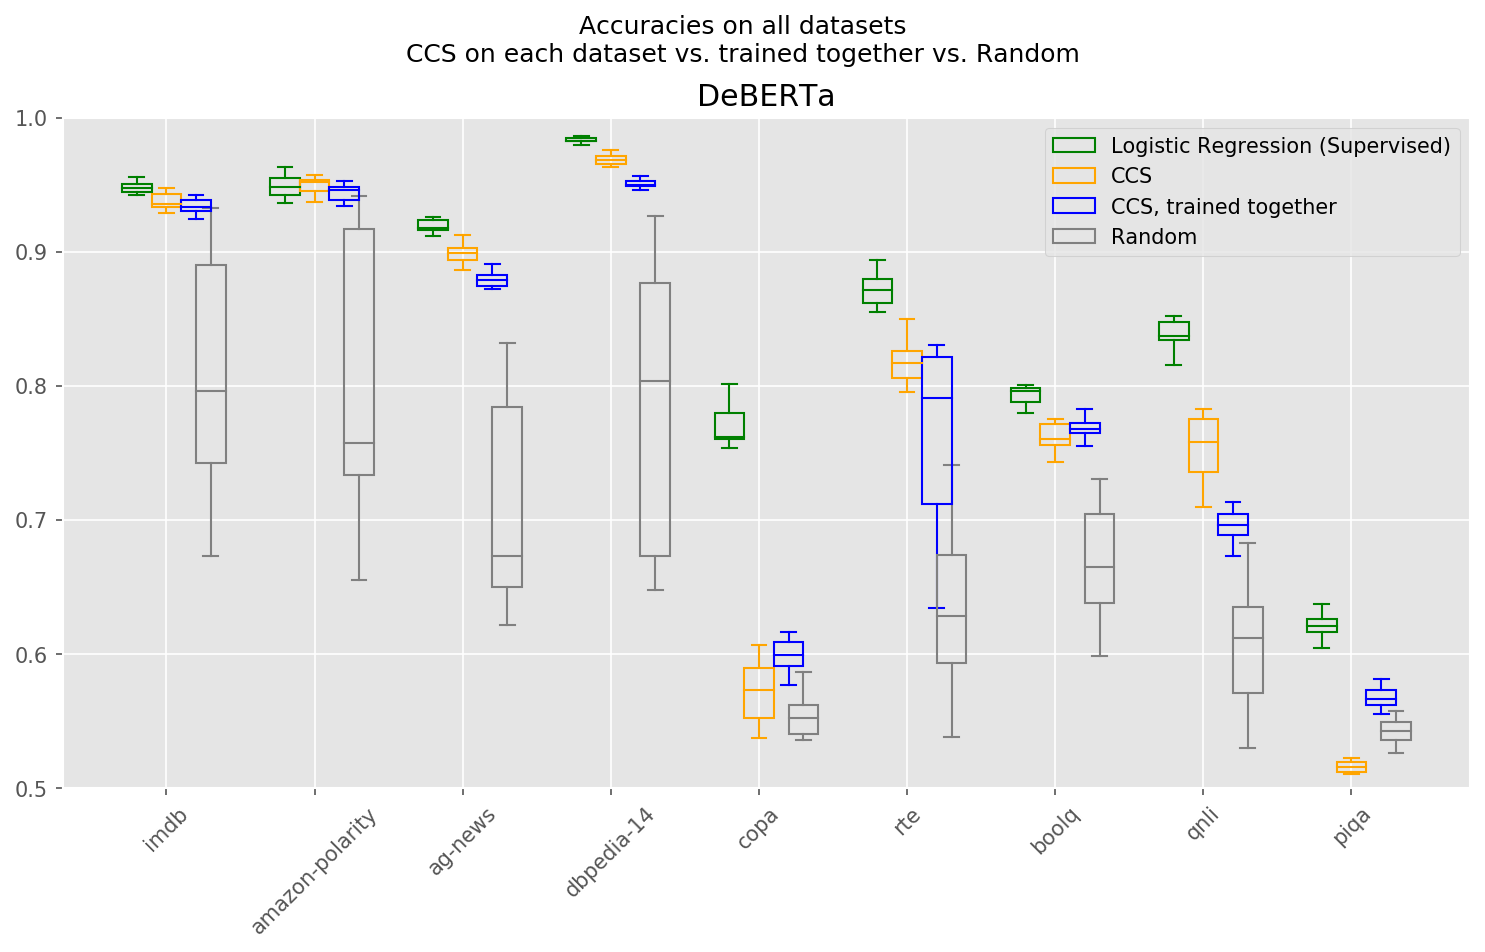

In [38]:
models = [DEBERTA]
prefix = "normal-dot"

fig, axs = plt.subplots(1, len(models), sharey=True)
if len(models) == 1:
    axs = [axs]

for i, (ax, model) in enumerate(zip(axs, models)):
    bar_names = MODEL_GOOD_DS[model]
    lr_accs = [
        load_stats(model, d, d, "LR", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    separate_accs = [
        load_stats(model, d, d, "CCS", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    together_accs = [
        load_stats(model, "all", d, "CCS", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    random_accs = [
        load_stats(model, "all", d, "Random", prefix=prefix)["accuracy"]
        for d in bar_names
    ]

    x_pos = np.arange(len(bar_names))
    width = 0.2
    legend_info = []
    legend_info += boxplots(
        x_pos - width,
        lr_accs,
        "Logistic Regression (Supervised)",
        LR_COL,
        width=width,
        obj=ax,
    )
    legend_info += boxplots(
        x_pos, separate_accs, "CCS", SEPARATE_COL, width=width, obj=ax
    )
    legend_info += boxplots(
        x_pos + width,
        together_accs,
        "CCS, trained together",
        TOGETHER_COL,
        width=width,
        obj=ax,
    )
    legend_info += boxplots(
        x_pos + 3 * width / 2,
        random_accs,
        "Random",
        RANDOM_COL,
        width=width,
        obj=ax,
    )
    if i == len(models) - 1:
        ax.legend([l[0] for l in legend_info], [l[1] for l in legend_info])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_names, rotation=45)
    ax.set_ylim(0.5, 1)
    ax.set_title(SHORT_NAMES[model])
plt.suptitle(
    f"Accuracies on all datasets\nCCS on each dataset vs. trained together vs. Random{TEST_ON_TRAIN_suffix}",
    y=1.05,
)
plt.tight_layout()
plt.show()

# CCS does not find the single direction with high accuracy

In [30]:
def plot_rccs_accs(ds, model, ax: plt.Axes, show_legend):
    if TEST_ON_TRAIN:
        return

    separate_accs = load_rccs_stats(model, ds, ds)["accuracy"]
    together_accs = load_rccs_stats(model, "all", ds)["accuracy"]

    rdm_accs = load_stats(model, ds, ds, "Random")["accuracy"]
    rdm_mean, rdm_std = np.mean(rdm_accs), np.std(rdm_accs)

    for accs, col, name in (
        [separate_accs, SEPARATE_COL, ""],
        [together_accs, TOGETHER_COL, " trained together"],
    ):
        if ds == "all" and col == SEPARATE_COL:
            continue

        mean_accs = np.mean(accs, axis=1)
        for i, acc in enumerate(accs.T):
            ax.plot(acc, color=col, alpha=0.2)
        ax.plot(mean_accs, color=col, label=f"CCS{name}, mean accuracy")
    ax.axhspan(
        rdm_mean - 2 * rdm_std,
        rdm_mean + 2 * rdm_std,
        color=RANDOM_COL,
        alpha=0.2,
        label="random accuracy (2 std)",
    )
    ax.set_ylim(0.5, 1)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Iteration of RCCS")
    ax.set_xticks(np.arange(0, RCCS_ITERS, 4))
    if show_legend:
        ax.legend()
    ax.set_title(SHORT_NAMES[model])


# TODO: plot this after running RCCS
# models = [DEBERTA]
# for ds in ["all", "imdb"]:
#     fig, axs = plt.subplots(1, len(models), sharey=True)
#     if len(models) == 1:
#         axs = [axs]
#     for ax, model in zip(axs, models):
#         plot_rccs_accs(ds, model, ax, show_legend=(model == GPTJ))
#     ds = "all datasets (average)" if ds == "all" else ds
#     plt.suptitle(
#         f"Recursive CCS accuracies on {ds}\n(5 runs){TEST_ON_TRAIN_suffix}",
#         y=1.05,
#     )
#     plt.tight_layout()
#     plt.show()

# Given that there are many “good” directions, does CCS always find roughly the same one?

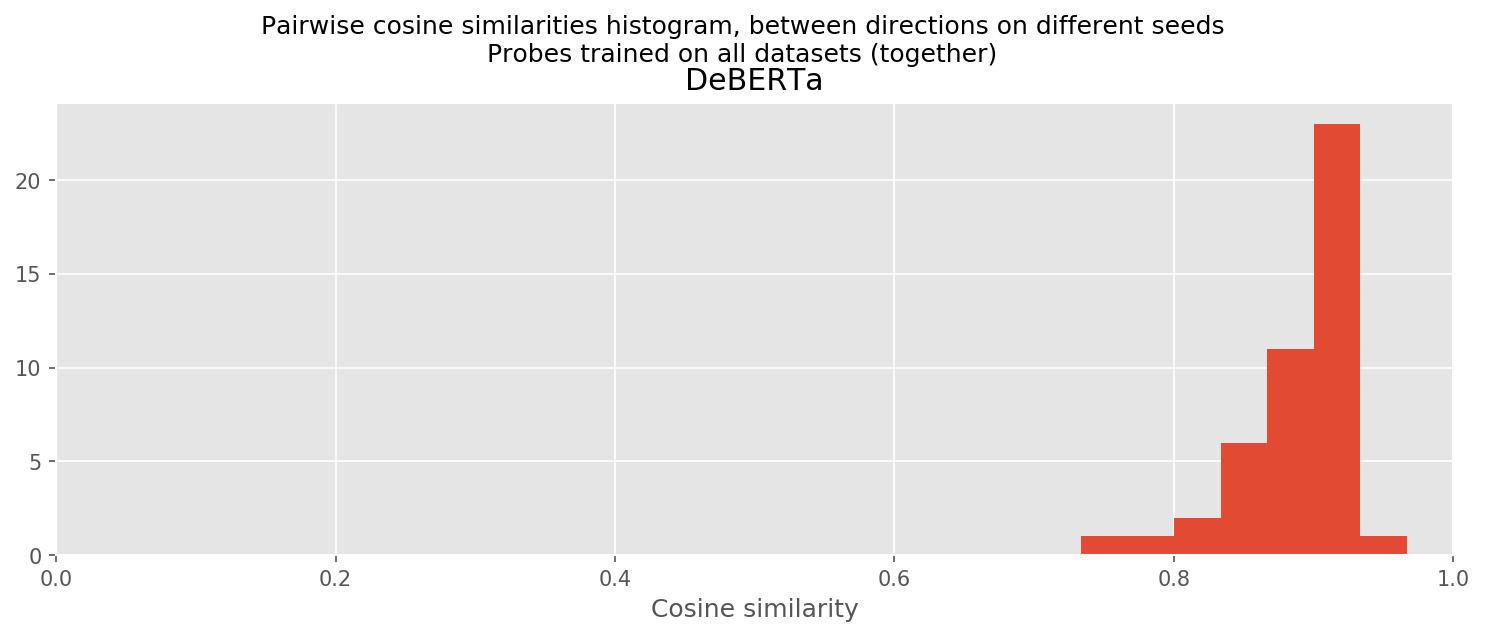

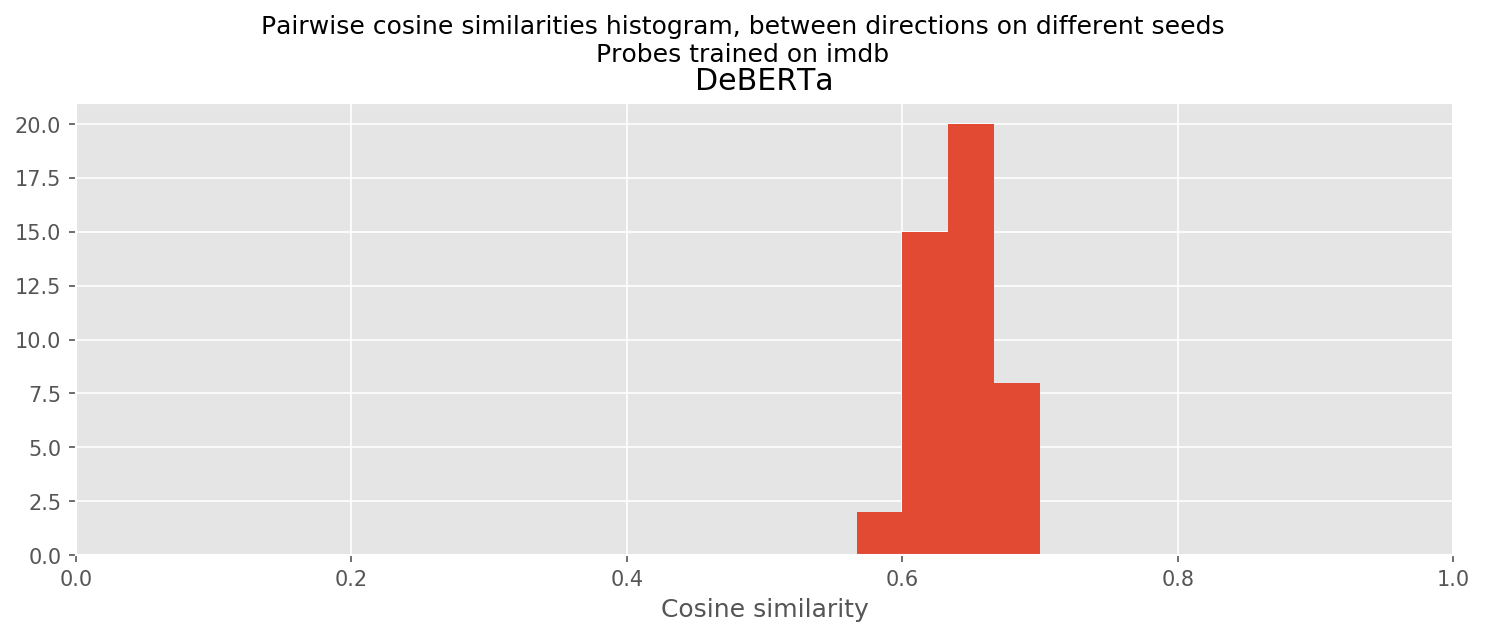

In [33]:
models = [DEBERTA]
prefix = "normal-dot"

for dataset in ["all", "imdb"]:
    fig, axs = plt.subplots(1, len(models), figsize=(10, 4))
    if len(models) == 1:
        axs = [axs]
    for ax, model in zip(axs, models):
        params = load_params(model, dataset, prefix=prefix, method="CCS")[
            "coefs"
        ].squeeze(1)
        cosines = np.array(
            [
                abs(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2)))
                for p1, p2 in combinations(params, 2)
            ]
        )
        ax.hist(cosines, bins=30, range=(0, 1))
        ax.set_xlabel("Cosine similarity")
        ax.set_xlim(0, 1)
        ax.set_title(SHORT_NAMES[model])
    plt.suptitle(
        f"Pairwise cosine similarities histogram, between directions on different seeds\nProbes trained on {'all datasets (together)' if dataset == 'all' else dataset}{TEST_ON_TRAIN_suffix}",
        y=1.05,
    )
    plt.tight_layout()
    plt.show()

# Ablating along the difference of the means direction makes both CCS & Supervised learning fail

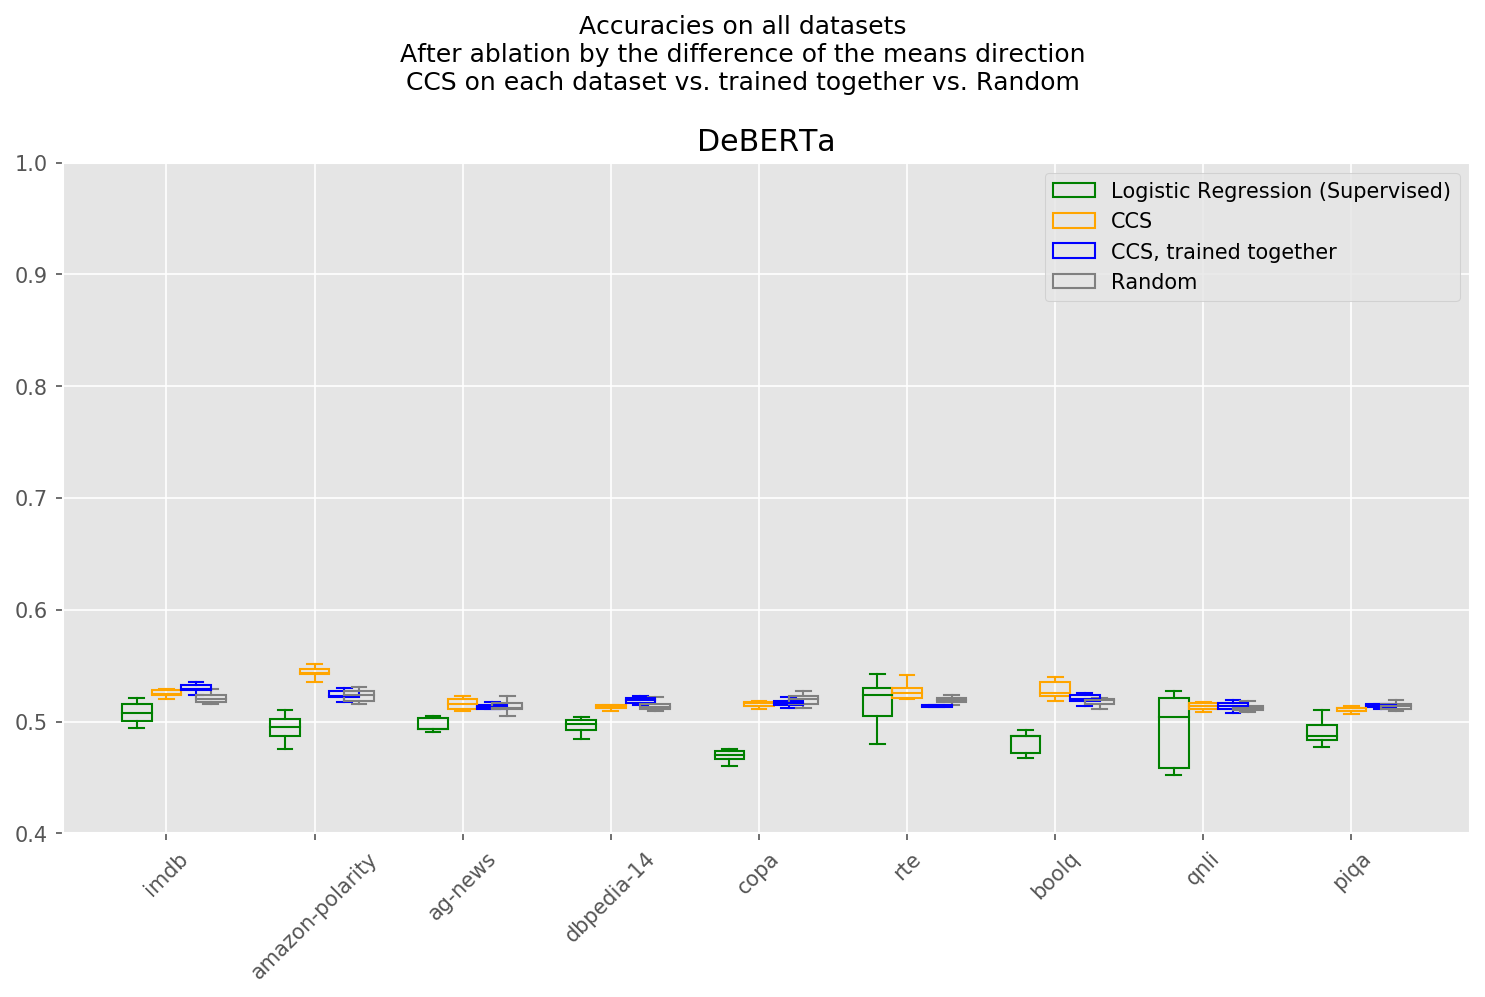

In [39]:
models = [DEBERTA]
prefix = "normal-dot"

fig, axs = plt.subplots(1, len(models), sharey=True)
if len(models) == 1:
    axs = [axs]

for i, (ax, model) in enumerate(zip(axs, models)):
    bar_names = MODEL_GOOD_DS[model]
    lr_accs = [
        load_stats(model, d, d, "LR-md", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    separate_accs = [
        load_stats(model, d, d, "CCS-md", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    together_accs = [
        load_stats(model, "all", d, "CCS-md", prefix=prefix)["accuracy"]
        for d in bar_names
    ]
    random_accs = [
        load_stats(model, "all", d, "Random-md", prefix=prefix)["accuracy"]
        for d in bar_names
    ]

    x_pos = np.arange(len(bar_names))
    width = 0.2
    legend_info = []
    legend_info += boxplots(
        x_pos - width,
        lr_accs,
        "Logistic Regression (Supervised)",
        LR_COL,
        width=width,
        obj=ax,
    )
    legend_info += boxplots(
        x_pos, separate_accs, "CCS", SEPARATE_COL, width=width, obj=ax
    )
    legend_info += boxplots(
        x_pos + width,
        together_accs,
        "CCS, trained together",
        TOGETHER_COL,
        width=width,
        obj=ax,
    )
    legend_info += boxplots(
        x_pos + 3 * width / 2,
        random_accs,
        "Random",
        RANDOM_COL,
        width=width,
        obj=ax,
    )
    if i == len(models) - 1:
        ax.legend([l[0] for l in legend_info], [l[1] for l in legend_info])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_names, rotation=45)
    ax.set_ylim(0.4, 1)
    ax.set_title(SHORT_NAMES[model])
plt.suptitle(
    f"""Accuracies on all datasets
After ablation by the difference of the means direction
CCS on each dataset vs. trained together vs. Random{TEST_ON_TRAIN_suffix}""",
    y=1.1,
)
plt.tight_layout()
plt.show()

# CCS does not find a probe with low test CCS loss

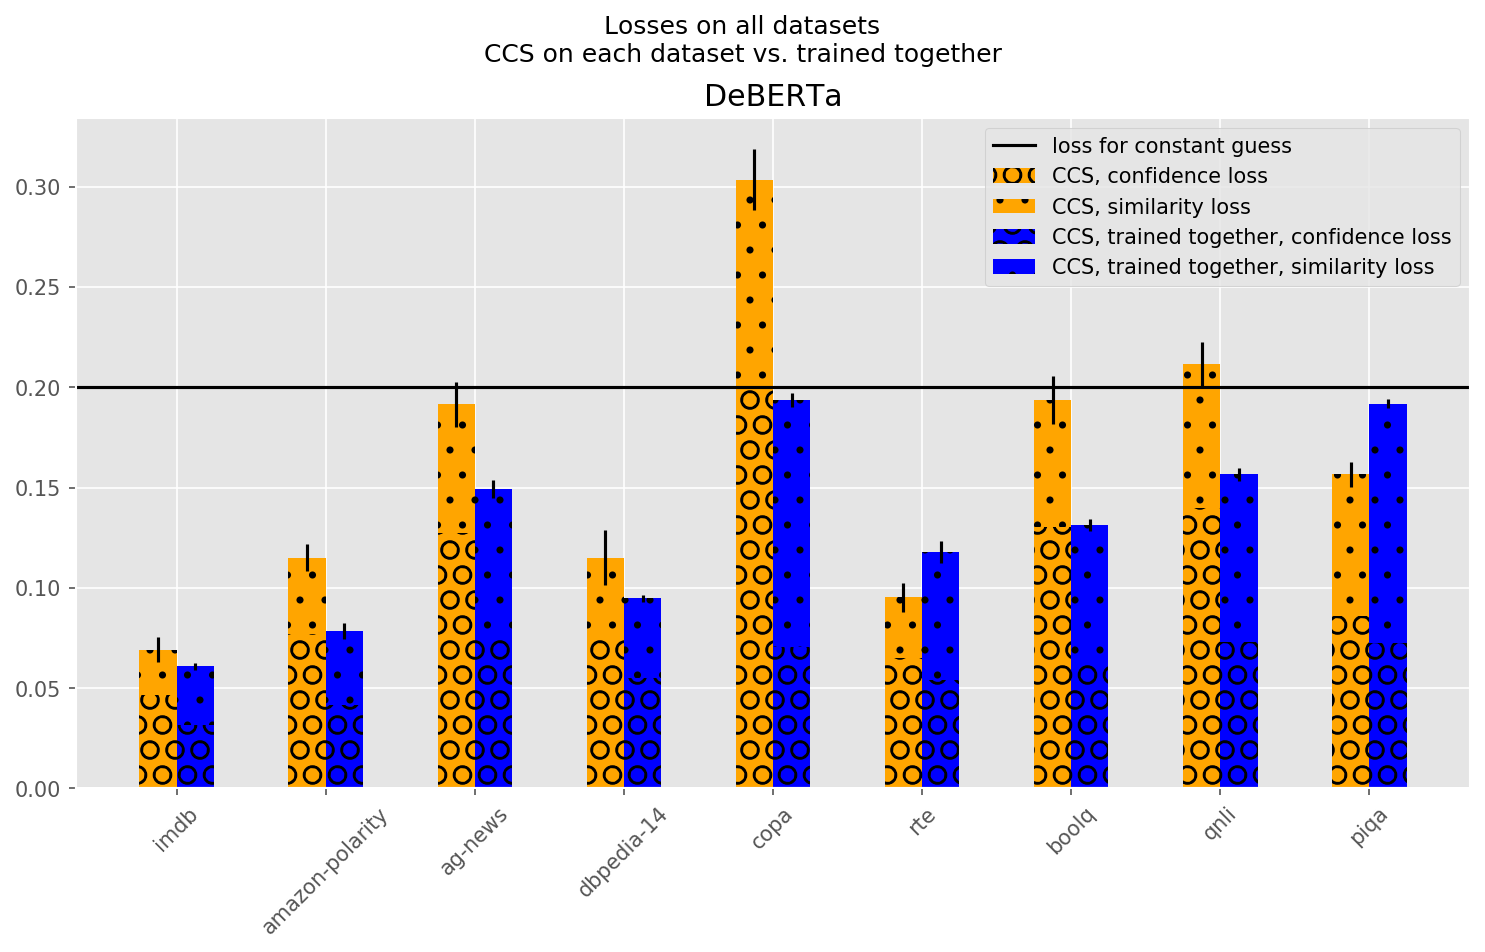

In [42]:
models = [DEBERTA]
prefix = "normal-dot"

fig, axs = plt.subplots(1, len(models), sharey=True)
if len(models) == 1:
    axs = [axs]

for i, (ax, model) in enumerate(zip(axs, models)):
    bar_names = MODEL_GOOD_DS[model]
    separate_sim_losses = [
        load_stats(model, d, d, "CCS", prefix=prefix)["sim_loss"]
        for d in bar_names
    ]
    together_sim_losses = [
        load_stats(model, "all", d, "CCS", prefix=prefix)["sim_loss"]
        for d in bar_names
    ]
    separate_cons_losses = [
        load_stats(model, d, d, "CCS", prefix=prefix)["cons_loss"]
        for d in bar_names
    ]
    together_cons_losses = [
        load_stats(model, "all", d, "CCS", prefix=prefix)["cons_loss"]
        for d in bar_names
    ]

    x_pos = np.arange(len(bar_names))
    width = 0.25
    plot_stacked_bar(
        x_pos - width / 2,
        separate_sim_losses,
        separate_cons_losses,
        "CCS",
        SEPARATE_COL,
        width,
        ax,
    )
    plot_stacked_bar(
        x_pos + width / 2,
        together_sim_losses,
        together_cons_losses,
        "CCS, trained together",
        TOGETHER_COL,
        width,
        ax,
    )

    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_names, rotation=45)
    ax.axhline(0.2, color="black", label="loss for constant guess")
    ax.axhline(0, color="lightgray")
    if i == len(models) - 1:
        ax.legend(loc="upper right")
    ax.set_title(SHORT_NAMES[model])

plt.suptitle(
    f"Losses on all datasets\nCCS on each dataset vs. trained together{TEST_ON_TRAIN_suffix}",
    y=1.05,
)
plt.tight_layout()
plt.show()

# My reproduction of Collin’s plots

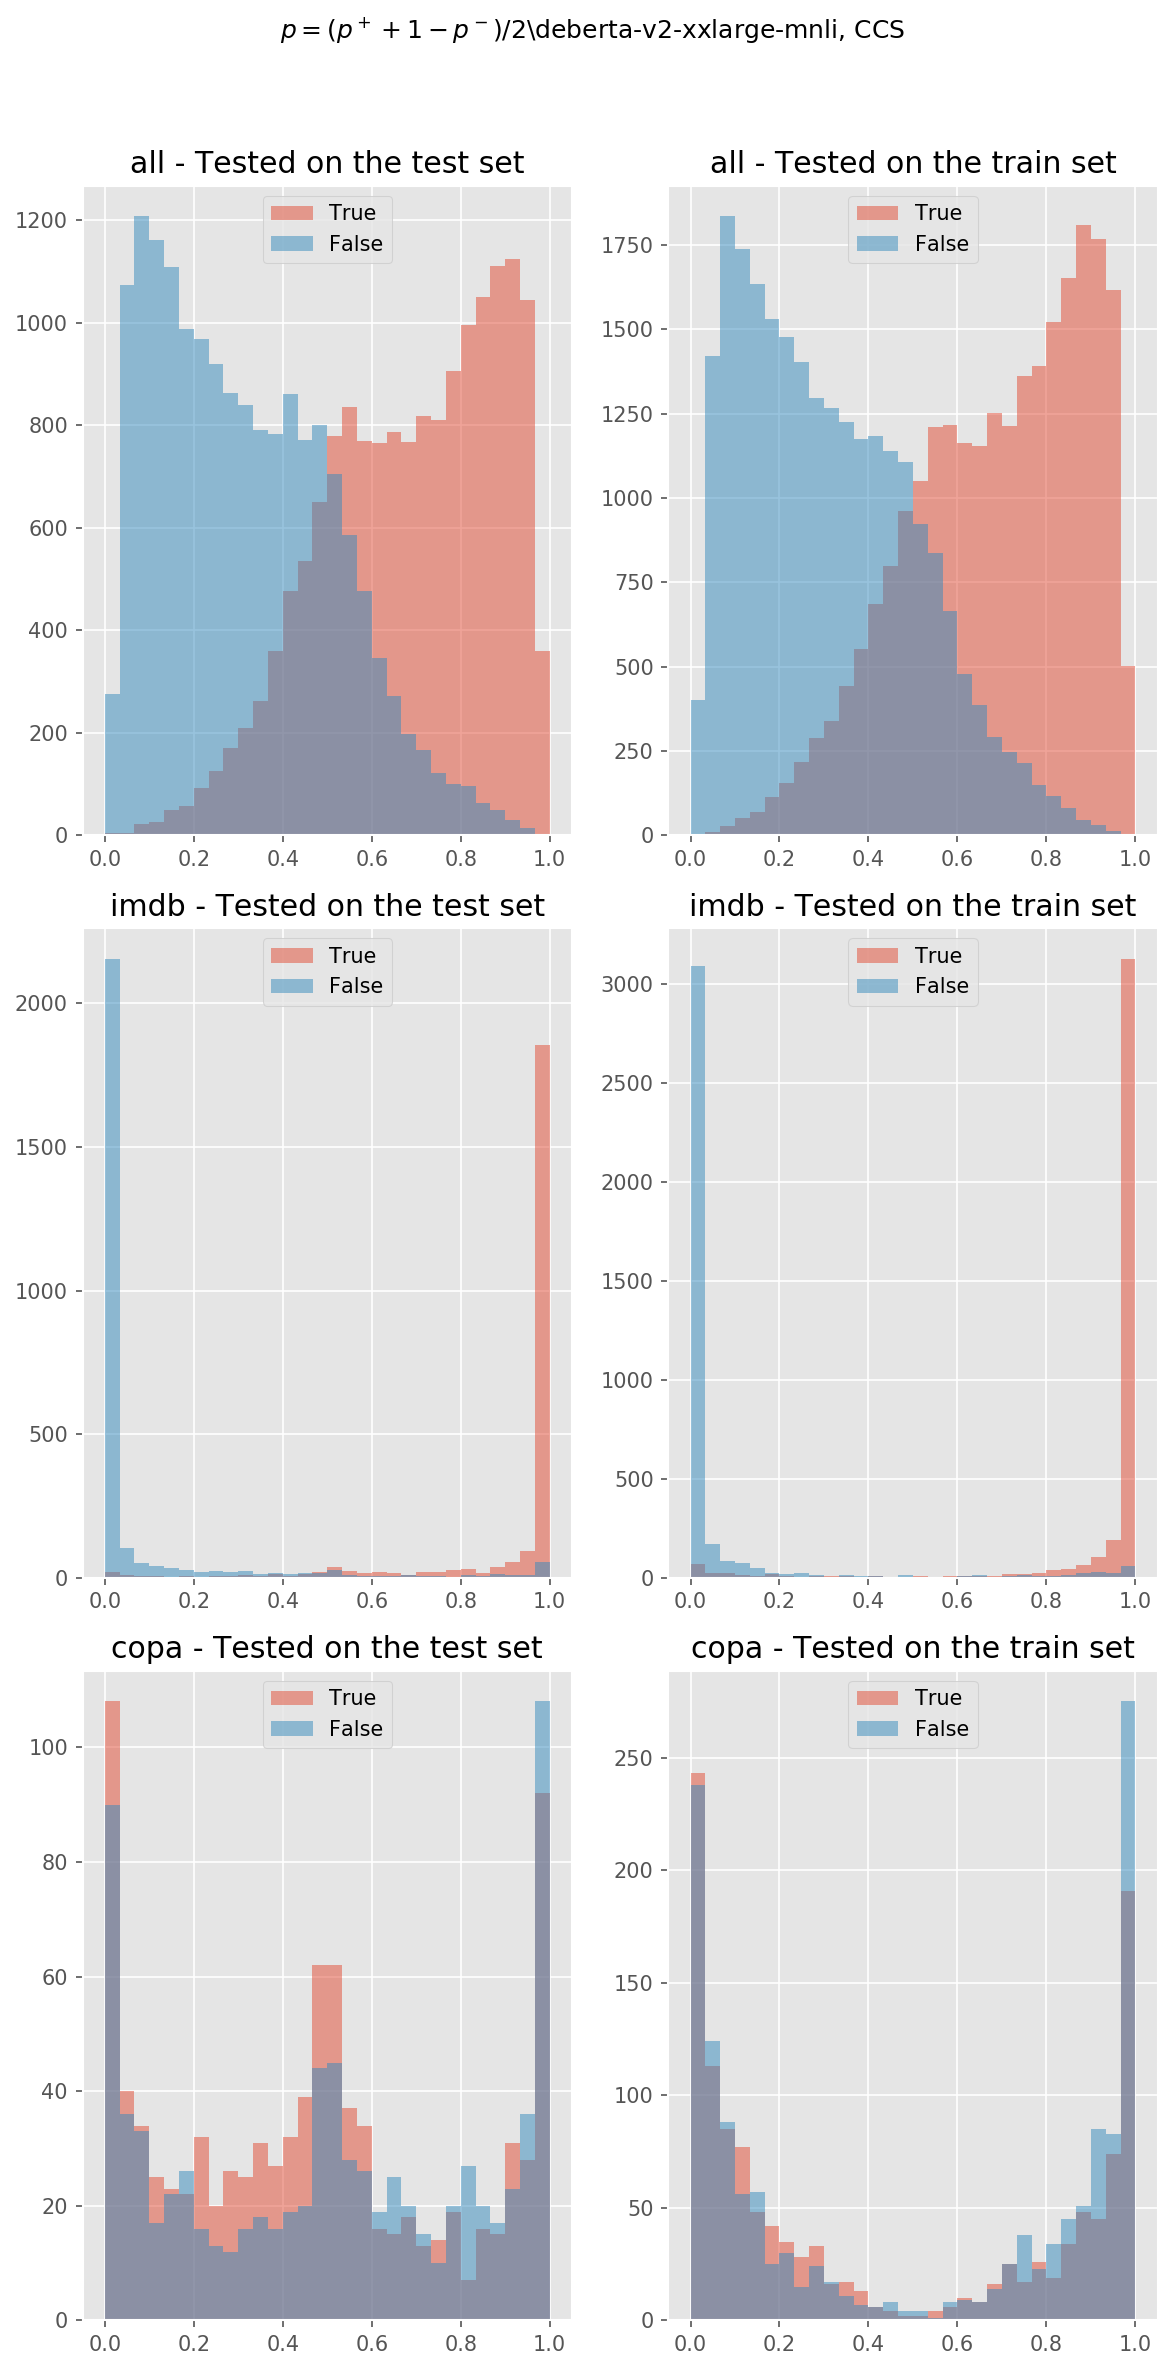

In [47]:
# TODO: how is the prefix being used to properly load in the extraction results?
# I'm not passing in prefix here.
prefix = "normal-dot"
model = DEBERTA
datasets = ["all", "imdb", "copa"]

fig, axs = plt.subplots(len(datasets), 2, figsize=(8, 5 * len(datasets)))

for ax_row, ds in zip(axs, datasets):
    for ax, test_on_train in zip(ax_row, [False, True]):
        save_dir = SAVE_DIR / "test_on_train" if test_on_train else SAVE_DIR
        probs = load_probs(model, ds, ds, "CCS", save_dir=save_dir)
        p0, p1, labels = probs.values.T
        p = (p1 + (1 - p0)) / 2
        true = p[labels == 1]
        false = p[labels == 0]
        ax.hist(true, bins=30, alpha=0.5, label="True", range=(0, 1))
        ax.hist(false, bins=30, alpha=0.5, label="False", range=(0, 1))
        if test_on_train:
            title = f"{ds} - Tested on the train set"
        else:
            title = f"{ds} - Tested on the test set"
        ax.set_title(title)
        ax.legend(loc="upper center")
plt.suptitle(f"$p = (p^+ + 1 - p^-)/2$\{model}, CCS", y=1.05)
plt.tight_layout()
plt.show()

# CCS does not find truth when the model doesn’t try to predict a truth-relevant output

In [48]:
# TODO: run this after running the extraction for multiple prefixes.

# models = [DEBERTA]

# prefixes = ["normal", "normal-dot", "normal-thatsright", "normal-mark"]
# prefix_explanations = {
#     # "normal": "No suffix",
#     "normal-dot": "{Q&A}.",
#     "normal-thatsright": "{Q&A}That's right!",
#     "normal-mark": "{Q&A}Mark for this question:",
# }

# layer_to_save_dir = {
#     "\nlast layer": SAVE_DIR,
#     # "\n4th layer before last": SAVE_DIR / "layer-5",
#     "\n8th layer before last": SAVE_DIR / "layer-9",
# }

# prefix_to_hashes = {
#     # "normal": "",
#     "normal-dot": "O",
#     "normal-thatsright": "////",
#     "normal-mark": "\\\\\\\\",
# }
# n_prefixes = len(prefix_to_hashes)

# fig, axs = plt.subplots(
#     len(models), len(layer_to_save_dir), figsize=(12, 14), squeeze=False
# )

# for j, (layer_name, save_dir) in enumerate(layer_to_save_dir.items()):
#     for i, model in enumerate(models):
#         ax = axs[i, j]

#         legend_info = []
#         for i, (prefix, hatches) in enumerate(prefix_to_hashes.items()):
#             width = 0.23
#             prefix_offset = (i - n_prefixes // 2) * width / n_prefixes

#             bar_names = MODEL_GOOD_DS[model]
#             lr_accs = [
#                 load_stats(model, d, d, "LR", prefix=prefix, save_dir=save_dir)[
#                     "accuracy"
#                 ]
#                 for d in bar_names
#             ]
#             separate_accs = [
#                 load_stats(
#                     model, d, d, "CCS", prefix=prefix, save_dir=save_dir
#                 )["accuracy"]
#                 for d in bar_names
#             ]
#             together_accs = [
#                 load_stats(
#                     model, "all", d, "CCS", prefix=prefix, save_dir=save_dir
#                 )["accuracy"]
#                 for d in bar_names
#             ]
#             random_accs = [
#                 load_stats(
#                     model, "all", d, "Random", prefix=prefix, save_dir=save_dir
#                 )["accuracy"]
#                 for d in bar_names
#             ]

#             x_pos = np.arange(len(bar_names))

#             explanation = " " + prefix_explanations[prefix]

#             bar_width = width / n_prefixes
#             legend_info += boxplots(
#                 x_pos - 3 * width / 2 + prefix_offset,
#                 lr_accs,
#                 "LR" + explanation,
#                 LR_COL,
#                 width=bar_width,
#                 obj=ax,
#                 hatches=hatches,
#             )
#             legend_info += boxplots(
#                 x_pos - width / 2 + prefix_offset,
#                 separate_accs,
#                 "CCS" + explanation,
#                 SEPARATE_COL,
#                 width=bar_width,
#                 obj=ax,
#                 hatches=hatches,
#             )
#             legend_info += boxplots(
#                 x_pos + width / 2 + prefix_offset,
#                 together_accs,
#                 "CCS together" + explanation,
#                 TOGETHER_COL,
#                 width=bar_width,
#                 obj=ax,
#                 hatches=hatches,
#             )
#             legend_info += boxplots(
#                 x_pos + 3 * width / 2 + prefix_offset,
#                 random_accs,
#                 "Rdm" + explanation,
#                 RANDOM_COL,
#                 width=bar_width,
#                 obj=ax,
#                 hatches=hatches,
#             )
#         ax.set_xticks(x_pos)
#         ax.set_xticklabels(bar_names, rotation=45)
#         ax.set_ylim(0.5, 1)
#         ax.set_title(SHORT_NAMES[model] + layer_name)

# if model == GPTJ:
#     # reorganize legend
#     legend_info = (
#         legend_info[0::4]
#         + legend_info[1::4]
#         + legend_info[2::4]
#         + legend_info[3::4]
#     )
#     axs[0, 1].legend(
#         [l[0] for l in legend_info],
#         [l[1] for l in legend_info],
#         loc="upper right",
#     )

# plt.suptitle(
#     f"Accuracies on all datasets\nCCS on each dataset vs. trained together vs. Random{TEST_ON_TRAIN_suffix}", y=1.05
# )
# plt.tight_layout()
# plt.show()